<a href="https://colab.research.google.com/github/AravindR7/donorschoose-application-screening/blob/master/Application_Screening.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict whether teachers' project proposals are accepted

- The goal the project is to predict wheather the project proposal submitted by teacher  will be approved or not.


## 1. Load the necessary libraries

In [1]:
!pip install squarify


In [2]:
import pandas as pd # for data manipulation
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for making plots with seaborn
color = sns.color_palette()
import plotly.offline as py
py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.offline as offline
offline.init_notebook_mode()
import plotly.tools as tls
import squarify
import mpl_toolkits
# from mpl_toolkits.basemap import Basemap
from numpy import array
from matplotlib import cm

# avoid unnecessary warnings so that presentation looks clean
import warnings
warnings.filterwarnings("ignore")

# Print all rows and columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from textblob import TextBlob
import datetime as dt
import warnings
import string
import time
# stop_words = []
stop_words = list(set(stopwords.words('english')))
warnings.filterwarnings('ignore')
punctuation = string.punctuation

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Load the data
train_data = pd.read_csv("/content/drive/My Drive/donorschoose-application-screening/train/train.csv")
test_data = pd.read_csv('/content/drive/My Drive/donorschoose-application-screening/test/test.csv')             # Add the path the data.
resources_data = pd.read_csv('/content/drive/My Drive/donorschoose-application-screening/resources/resources.csv')

# lets merge train and test data
train_resource = pd.merge(train_data, resources_data, on="id", how='left')
test_resource = pd.merge(test_data, resources_data, on='id', how='left')

In [4]:
print("Size of training data:", train_data.shape)
print("Size of test data:", test_data.shape)
print("Size of resource data:", resources_data.shape)
print("Size of train_resource data:", train_resource.shape)
print("Size of test_resource data:", test_resource.shape)

Size of training data: (182080, 16)
Size of test data: (78035, 15)
Size of resource data: (1541272, 4)
Size of train_resource data: (1081830, 19)
Size of test_resource data: (459442, 18)


In [5]:
# Print first 5 rows
train_data.head()

id                        teacher_id teacher_prefix school_state  \
0  p036502  484aaf11257089a66cfedc9461c6bd0a            Ms.           NV   
1  p039565  df72a3ba8089423fa8a94be88060f6ed           Mrs.           GA   
2  p233823  a9b876a9252e08a55e3d894150f75ba3            Ms.           UT   
3  p185307  525fdbb6ec7f538a48beebaa0a51b24f            Mr.           NC   
4  p013780  a63b5547a7239eae4c1872670848e61a            Mr.           CA   

  project_submitted_datetime project_grade_category  \
0        2016-11-18 14:45:59          Grades PreK-2   
1        2017-04-26 15:57:28             Grades 3-5   
2        2017-01-01 22:57:44             Grades 3-5   
3        2016-08-12 15:42:11             Grades 3-5   
4        2016-08-06 09:09:11             Grades 6-8   

            project_subject_categories  \
0                  Literacy & Language   
1    Music & The Arts, Health & Sports   
2  Math & Science, Literacy & Language   
3                      Health & Sports   
4                      Health & Sports   

            project_subject_subcategories  \
0                                Literacy   
1            Performing Arts, Team Sports   
2  Applied Sciences, Literature & Writing   
3                       Health & Wellness   
4                       Health & Wellness   

                                       project_title  \
0                           Super Sight Word Centers   
1                             Keep Calm and Dance On   
2                              Lets 3Doodle to Learn   
3  \"Kid Inspired\" Equipment to Increase Activit...   
4   We need clean water for our culinary arts class!   

                                     project_essay_1  \
0  Most of my kindergarten students come from low...   
1  Our elementary school is a culturally rich sch...   
2  Hello;\r\nMy name is Mrs. Brotherton. I teach ...   
3  My students are the greatest students but are ...   
4  My students are athletes and students who are ...   

                                     project_essay_2 project_essay_3  \
0  I currently have a differentiated sight word c...             NaN   
1  We strive to provide our diverse population of...             NaN   
2  We are looking to add some 3Doodler to our cla...             NaN   
3  The student's project which is totally \"kid-i...             NaN   
4  For some reason in our kitchen the water comes...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need 6 Ipod Nano's to create and d...   
1             NaN  My students need matching shirts to wear for d...   
2             NaN  My students need the 3doodler. We are an SEM s...   
3             NaN  My students need balls and other activity equi...   
4             NaN  My students need a water filtration system for...   

   teacher_number_of_previously_posted_projects  project_is_approved  
0                                            26                    1  
1                                             1                    0  
2                                             5                    1  
3                                            16                    0  
4                                            42                    1

In [6]:
test_data.head()

id                        teacher_id teacher_prefix school_state  \
0  p233245  5724a0c3ce11008366fff36dab4b943c            Ms.           CA   
1  p096795  445619941dc7cbe81c7be109dc61a56a           Mrs.           SC   
2  p236235  e92a4902b1611a189643d6f12c51e6a0           Mrs.           SC   
3  p233680  8e92622d2985d3faac1de71609c4be72           Mrs.           IA   
4  p171879  91a3c89981f626d9a0d067c65fb186ce            Mr.           CA   

  project_submitted_datetime project_grade_category  \
0        2016-04-27 13:45:41          Grades PreK-2   
1        2016-04-28 12:43:56             Grades 3-5   
2        2016-04-29 21:16:05          Grades PreK-2   
3        2016-04-27 22:32:43          Grades PreK-2   
4        2016-04-27 18:59:15             Grades 6-8   

            project_subject_categories      project_subject_subcategories  \
0                     Music & The Arts                        Visual Arts   
1  Literacy & Language, Math & Science  Literature & Writing, Mathematics   
2                       Math & Science      Applied Sciences, Mathematics   
3                  Literacy & Language                           Literacy   
4      Music & The Arts, Special Needs     Performing Arts, Special Needs   

                         project_title  \
0             Art Will Make You Happy!   
1            Keeping up with the TIMEs   
2  Building Bridges to Problem Solving   
3                    Classroom Library   
4                 Reeds so we can Read   

                                     project_essay_1  \
0  My 2nd grade students are amazing!  They are v...   
1  Students within the classroom work in small gr...   
2  My students share  a love of learning. These s...   
3  Reading is the gateway to the soul.  Guiding c...   
4  \"Mr. Reyes!  I need another reed!\"  I hear t...   

                                     project_essay_2  \
0  My class is made up of 12 boys and 12 girls.  ...   
1  My students are all very talented young indivi...   
2  My class consists of 14 energetic learners.  O...   
3  First graders enter the classroom each day rea...   
4  We have a diverse population with almost entir...   

                                     project_essay_3  \
0  My second grade class will really benefit from...   
1  We do a lot of small group, where the student ...   
2  These Fairy Tale Problem Solving STEM kits wil...   
3  Book bins will help to organize our classroom ...   
4  Each day in my class students consume supplies...   

                                     project_essay_4  \
0  The genorous donations to my project will make...   
1  This project is very important to my classroom...   
2  These materials will be help my students with ...   
3  When students begin the first grade, many are ...   
4  My students come from very troubled homes and ...   

                            project_resource_summary  \
0  My students need a drying rack for their art p...   
1  My students need Time Magazines for next year ...   
2  My students need to be mentally stimulated to ...   
3   My students need an organized classroom library.   
4  My students need reeds to perform in class eac...   

   teacher_number_of_previously_posted_projects  
0                                             2  
1                                             1  
2                                             0  
3                                             0  
4                                             1

In [7]:
resources_data.head()

id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   
2  p069063  Cory Stories: A Kid's Book About Living With Adhd         1   
3  p069063  Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...         2   
4  p069063  EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...         3   

    price  
0  149.00  
1   14.95  
2    8.45  
3   13.59  
4   24.95

In [8]:
train_resource.head()

id                        teacher_id teacher_prefix school_state  \
0  p036502  484aaf11257089a66cfedc9461c6bd0a            Ms.           NV   
1  p036502  484aaf11257089a66cfedc9461c6bd0a            Ms.           NV   
2  p039565  df72a3ba8089423fa8a94be88060f6ed           Mrs.           GA   
3  p233823  a9b876a9252e08a55e3d894150f75ba3            Ms.           UT   
4  p185307  525fdbb6ec7f538a48beebaa0a51b24f            Mr.           NC   

  project_submitted_datetime project_grade_category  \
0        2016-11-18 14:45:59          Grades PreK-2   
1        2016-11-18 14:45:59          Grades PreK-2   
2        2017-04-26 15:57:28             Grades 3-5   
3        2017-01-01 22:57:44             Grades 3-5   
4        2016-08-12 15:42:11             Grades 3-5   

            project_subject_categories  \
0                  Literacy & Language   
1                  Literacy & Language   
2    Music & The Arts, Health & Sports   
3  Math & Science, Literacy & Language   
4                      Health & Sports   

            project_subject_subcategories  \
0                                Literacy   
1                                Literacy   
2            Performing Arts, Team Sports   
3  Applied Sciences, Literature & Writing   
4                       Health & Wellness   

                                       project_title  \
0                           Super Sight Word Centers   
1                           Super Sight Word Centers   
2                             Keep Calm and Dance On   
3                              Lets 3Doodle to Learn   
4  \"Kid Inspired\" Equipment to Increase Activit...   

                                     project_essay_1  \
0  Most of my kindergarten students come from low...   
1  Most of my kindergarten students come from low...   
2  Our elementary school is a culturally rich sch...   
3  Hello;\r\nMy name is Mrs. Brotherton. I teach ...   
4  My students are the greatest students but are ...   

                                     project_essay_2 project_essay_3  \
0  I currently have a differentiated sight word c...             NaN   
1  I currently have a differentiated sight word c...             NaN   
2  We strive to provide our diverse population of...             NaN   
3  We are looking to add some 3Doodler to our cla...             NaN   
4  The student's project which is totally \"kid-i...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need 6 Ipod Nano's to create and d...   
1             NaN  My students need 6 Ipod Nano's to create and d...   
2             NaN  My students need matching shirts to wear for d...   
3             NaN  My students need the 3doodler. We are an SEM s...   
4             NaN  My students need balls and other activity equi...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                            26                    1   
1                                            26                    1   
2                                             1                    0   
3                                             5                    1   
4                                            16                    0   

                                         description  quantity   price  
0  Apple - iPod nano� 16GB MP3 Player (8th Genera...         3  149.99  
1  Apple - iPod nano� 16GB MP3 Player (8th Genera...         3  149.99  
2  Reebok Girls' Fashion Dance Graphic T-Shirt - ...        20   20.00  
3                     3doodler Start Full Edu Bundle         1  469.99  
4                   BALL PG 4'' POLY SET OF 6 COLORS         1   18.95

In [9]:
test_resource.head()

id                        teacher_id teacher_prefix school_state  \
0  p233245  5724a0c3ce11008366fff36dab4b943c            Ms.           CA   
1  p096795  445619941dc7cbe81c7be109dc61a56a           Mrs.           SC   
2  p096795  445619941dc7cbe81c7be109dc61a56a           Mrs.           SC   
3  p096795  445619941dc7cbe81c7be109dc61a56a           Mrs.           SC   
4  p236235  e92a4902b1611a189643d6f12c51e6a0           Mrs.           SC   

  project_submitted_datetime project_grade_category  \
0        2016-04-27 13:45:41          Grades PreK-2   
1        2016-04-28 12:43:56             Grades 3-5   
2        2016-04-28 12:43:56             Grades 3-5   
3        2016-04-28 12:43:56             Grades 3-5   
4        2016-04-29 21:16:05          Grades PreK-2   

            project_subject_categories      project_subject_subcategories  \
0                     Music & The Arts                        Visual Arts   
1  Literacy & Language, Math & Science  Literature & Writing, Mathematics   
2  Literacy & Language, Math & Science  Literature & Writing, Mathematics   
3  Literacy & Language, Math & Science  Literature & Writing, Mathematics   
4                       Math & Science      Applied Sciences, Mathematics   

                         project_title  \
0             Art Will Make You Happy!   
1            Keeping up with the TIMEs   
2            Keeping up with the TIMEs   
3            Keeping up with the TIMEs   
4  Building Bridges to Problem Solving   

                                     project_essay_1  \
0  My 2nd grade students are amazing!  They are v...   
1  Students within the classroom work in small gr...   
2  Students within the classroom work in small gr...   
3  Students within the classroom work in small gr...   
4  My students share  a love of learning. These s...   

                                     project_essay_2  \
0  My class is made up of 12 boys and 12 girls.  ...   
1  My students are all very talented young indivi...   
2  My students are all very talented young indivi...   
3  My students are all very talented young indivi...   
4  My class consists of 14 energetic learners.  O...   

                                     project_essay_3  \
0  My second grade class will really benefit from...   
1  We do a lot of small group, where the student ...   
2  We do a lot of small group, where the student ...   
3  We do a lot of small group, where the student ...   
4  These Fairy Tale Problem Solving STEM kits wil...   

                                     project_essay_4  \
0  The genorous donations to my project will make...   
1  This project is very important to my classroom...   
2  This project is very important to my classroom...   
3  This project is very important to my classroom...   
4  These materials will be help my students with ...   

                            project_resource_summary  \
0  My students need a drying rack for their art p...   
1  My students need Time Magazines for next year ...   
2  My students need Time Magazines for next year ...   
3  My students need Time Magazines for next year ...   
4  My students need to be mentally stimulated to ...   

   teacher_number_of_previously_posted_projects  \
0                                             2   
1                                             1   
2                                             1   
3                                             1   
4                                             0   

                                         description  quantity   price  
0  LC652 - Lakeshore Double-Space Mobile Drying Rack         1  149.00  
1  Brewster WPD90218 Wall Pops Flirt Dot, Set of ...         2    9.95  
2  Brewster Wall Pops WPE99065 Peel & Stick Calyp...         2    9.02  
3  TIME For Kids - 3-4 PRINT Bundle - 24 issues /...        40    5.01  
4     PP440X - Fairy Tales Problem Solving STEM Kits         2  149.00

In [10]:
# Overview of data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182080 entries, 0 to 182079
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype 
---  ------                                        --------------   ----- 
 0   id                                            182080 non-null  object
 1   teacher_id                                    182080 non-null  object
 2   teacher_prefix                                182076 non-null  object
 3   school_state                                  182080 non-null  object
 4   project_submitted_datetime                    182080 non-null  object
 5   project_grade_category                        182080 non-null  object
 6   project_subject_categories                    182080 non-null  object
 7   project_subject_subcategories                 182080 non-null  object
 8   project_title                                 182080 non-null  object
 9   project_essay_1                               182080 non-nu

In [11]:
train_data.describe()

teacher_number_of_previously_posted_projects  project_is_approved
count                                 182080.000000        182080.000000
mean                                      11.237055             0.847682
std                                       28.016086             0.359330
min                                        0.000000             0.000000
25%                                        0.000000             1.000000
50%                                        2.000000             1.000000
75%                                        9.000000             1.000000
max                                      451.000000             1.000000

In [12]:
# for categorical features
train_data.describe(include=["O"])

id                        teacher_id teacher_prefix school_state  \
count    182080                            182080         182076       182080   
unique   182080                            104414              5           51   
top     p049147  fa2f220b537e8653fb48878ebb38044d           Mrs.           CA   
freq          1                                74          95405        25695   

       project_submitted_datetime project_grade_category  \
count                      182080                 182080   
unique                     180439                      4   
top           2016-09-01 00:00:03          Grades PreK-2   
freq                           30                  73890   

       project_subject_categories project_subject_subcategories  \
count                      182080                        182080   
unique                         51                           407   
top           Literacy & Language                      Literacy   
freq                        39257                         15775   

           project_title                                    project_essay_1  \
count             182080                                             182080   
unique            164282                                             147689   
top     Flexible Seating  As a teacher in a low-income/high poverty scho...   
freq                 377                                                 46   

                                          project_essay_2  \
count                                              182080   
unique                                             180984   
top     Students will be using Chromebooks to increase...   
freq                                                   24   

                                          project_essay_3  \
count                                                6374   
unique                                               6359   
top     I love to make learning fun for my students, h...   
freq                                                    2   

                                          project_essay_4  \
count                                                6374   
unique                                               6336   
top     Having taught engineering in college, I have c...   
freq                                                    3   

                                 project_resource_summary  
count                                              182080  
unique                                             179730  
top     My students need electronic tablets to do all ...  
freq                                                   84

In [13]:
train_resource.describe()

teacher_number_of_previously_posted_projects  project_is_approved  \
count                                  1.081830e+06         1.081830e+06   
mean                                   1.254963e+01         7.923777e-01   
std                                    3.038872e+01         4.056050e-01   
min                                    0.000000e+00         0.000000e+00   
25%                                    0.000000e+00         1.000000e+00   
50%                                    3.000000e+00         1.000000e+00   
75%                                    1.000000e+01         1.000000e+00   
max                                    4.510000e+02         1.000000e+00   

           quantity         price  
count  1.081830e+06  1.081830e+06  
mean   2.856420e+00  5.011038e+01  
std    7.529482e+00  1.431715e+02  
min    1.000000e+00  0.000000e+00  
25%    1.000000e+00  7.870000e+00  
50%    1.000000e+00  1.499000e+01  
75%    2.000000e+00  3.964000e+01  
max    8.000000e+02  9.999000e+03

In [14]:
train_resource.describe(include=['O'])

id                        teacher_id teacher_prefix school_state  \
count   1081830                           1081830        1081819      1081830   
unique   182080                            104414              5           51   
top     p009778  062339e2c5ca3b602351bb02ffef9ae4           Mrs.           CA   
freq        100                               739         546894       154076   

       project_submitted_datetime project_grade_category  \
count                     1081830                1081830   
unique                     180439                      4   
top           2016-09-01 00:00:03          Grades PreK-2   
freq                          347                 460457   

       project_subject_categories project_subject_subcategories  \
count                     1081830                       1081830   
unique                         51                           407   
top           Literacy & Language                      Literacy   
freq                       317477                        142889   

           project_title                                    project_essay_1  \
count            1081830                                            1081830   
unique            164282                                             147689   
top     Flexible Seating  Nestled in the heart of the South Bronx is an ...   
freq                1542                                                421   

                                          project_essay_2  \
count                                             1081830   
unique                                             180984   
top     Many of our students live in shelters and fost...   
freq                                                  173   

                                          project_essay_3  \
count                                               38157   
unique                                               6359   
top     My students will use the blocks to build tall ...   
freq                                                   94   

                                          project_essay_4  \
count                                               38157   
unique                                               6336   
top     According to the NAEYC, children who grow up i...   
freq                                                   94   

                                 project_resource_summary  \
count                                             1081830   
unique                                             179730   
top     My students need electronic tablets to do all ...   
freq                                                  171   

                                              description  
count                                             1081638  
unique                                             269995  
top     Apple - iPad� mini 2 with Wi-Fi - 16GB - Space...  
freq                                                 2171

## Check for the missing data 

In [15]:
# Check missing data in training values
total = train_data.isnull().sum().sort_values(ascending=False)

percent = (train_data.isnull().sum()/train_data.isnull().count()*100).sort_values(ascending = False)

missing_train_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_train_data.head()

Total    Percent
project_essay_4                               175706  96.499341
project_essay_3                               175706  96.499341
teacher_prefix                                     4   0.002197
project_is_approved                                0   0.000000
teacher_number_of_previously_posted_projects       0   0.000000

    project_essay_4 and project_essay_3 has 96% of null values so these 2 columns needs to be removed.

In [16]:
# Check missing data in resource values
total = resources_data.isnull().sum().sort_values(ascending=False)

percent = (resources_data.isnull().sum()/resources_data.isnull().count()*100).sort_values(ascending = False)

missing_train_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_train_data.head()

Total   Percent
description    292  0.018945
price            0  0.000000
quantity         0  0.000000
id               0  0.000000

missing values in "description" is very small so it can be neglected

# Exploratory data analysis
- Project is approved or not
- Distribution of school states


In [17]:
temp = train_data['project_is_approved'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Project proposal is approved or not')
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig);

    Training data is highly imbalanced 85% of projects were approved and 15% of projects were not approved. Majority immbalanced class is positive

## Distribution of school states

In [18]:
temp = train_data["school_state"].value_counts()
#print("Total number of states : ",len(temp))
trace = go.Bar(
    x = temp.index,
    y = (temp / temp.sum())*100,
)
data = [trace]
layout = go.Layout(
    title = "Distribution of School states in % ",
    xaxis=dict(
        title='State Name',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count of project proposals submitted in %',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='schoolStateNames')

In [19]:
# Distribution of category of the project
temp = train_data["project_subject_categories"].value_counts().head(10)
print("Total number of project subject categories : ", len(train_data["project_subject_categories"].value_counts()))
trace = go.Bar(
    x = temp.index,
    y = (temp / temp.sum())*100,
)
data = [trace]
layout = go.Layout(
    title = "Distribution of category of the project in %",
    xaxis=dict(
        title='category of the project',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count of project proposals submitted in %',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='schoolStateNames')

Total number of project subject categories :  51


# Distribution of number of previously posted applications by the submitting teacher

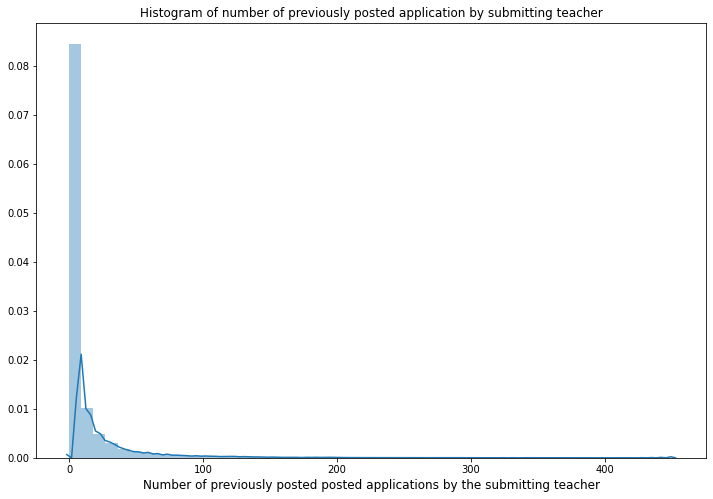

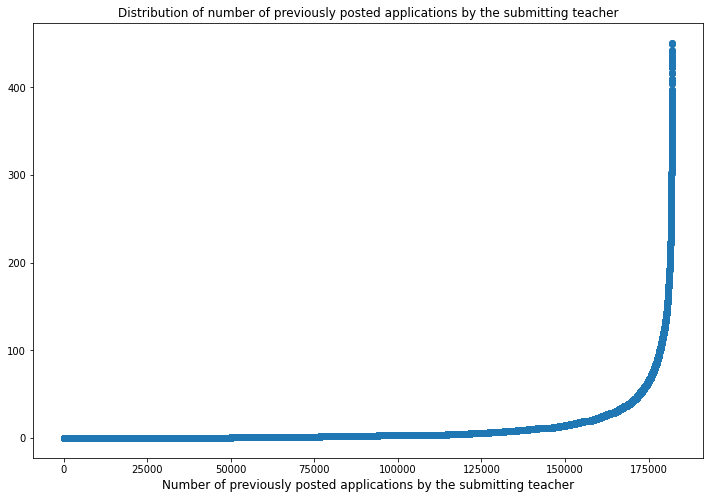

In [20]:
plt.figure(figsize = (12, 8))

sns.distplot(train_data['teacher_number_of_previously_posted_projects'])
plt.xlabel('Number of previously posted posted applications by the submitting teacher', fontsize=12)
plt.title("Histogram of number of previously posted application by submitting teacher")
plt.show();
plt.figure(figsize=(12, 8))
plt.scatter(range(train_data.shape[0]), np.sort(train_data.teacher_number_of_previously_posted_projects.values))
plt.xlabel('Number of previously posted applications by the submitting teacher', fontsize=12)
plt.title("Distribution of number of previously posted applications by the submitting teacher")
plt.show()

# Distribution of subcategory of project can also be plotted

## Distribution of project title

# Distribution of price of resources requested

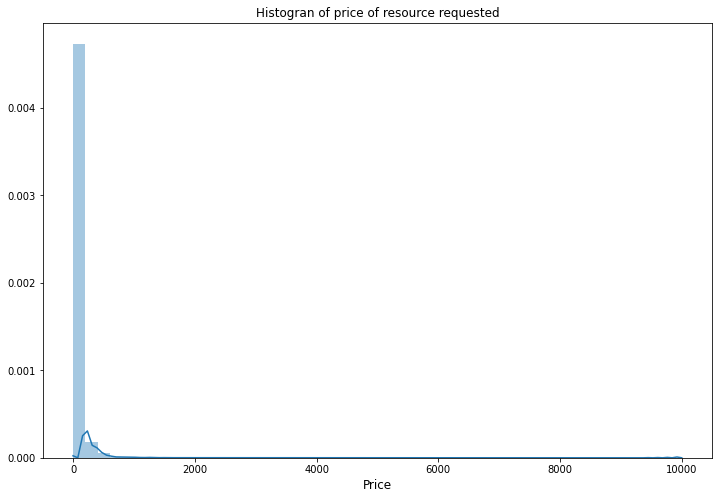

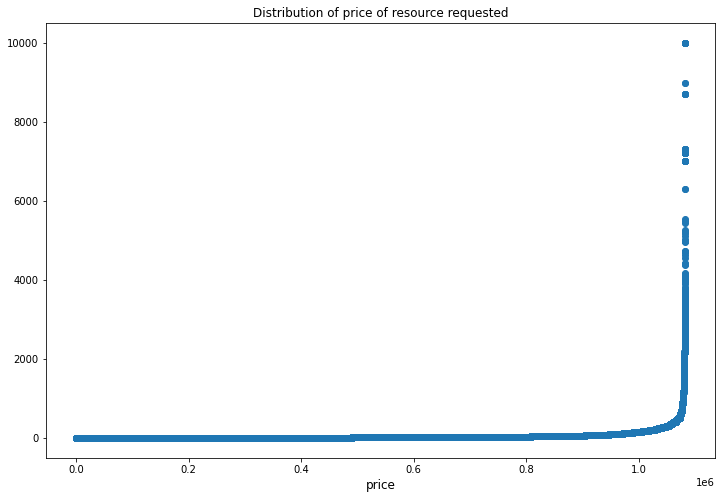

In [21]:
plt.figure(figsize = (12, 8))

sns.distplot(train_resource['price'])
plt.xlabel('Price', fontsize=12)
plt.title("Histogran of price of resource requested")
plt.show() 
plt.figure(figsize = (12, 8))
plt.scatter(range(train_resource.shape[0]), np.sort(train_resource.price.values))
plt.xlabel('price', fontsize=12)
plt.title("Distribution of price of resource requested")
plt.show()

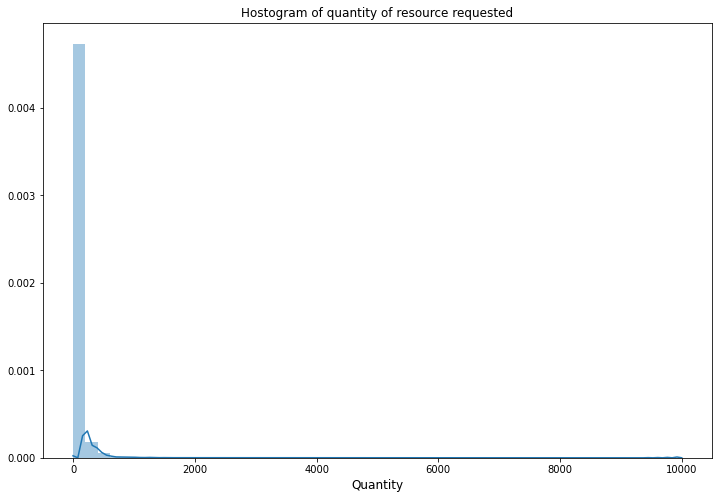

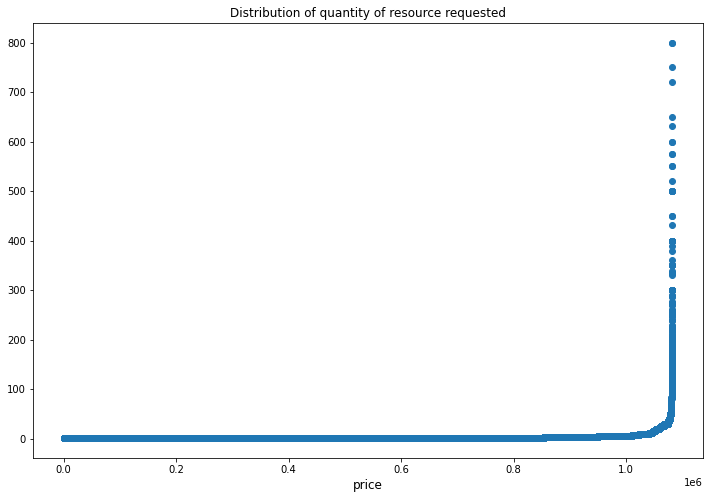

In [22]:
plt.figure(figsize = (12, 8))

sns.distplot(train_resource['price'])
plt.xlabel('Quantity', fontsize=12)
plt.title('Hostogram of quantity of resource requested')
plt.show()
plt.figure(figsize=(12,8))
plt.scatter(range(train_resource.shape[0]), np.sort(train_resource.quantity.values))
plt.xlabel('price', fontsize=12)
plt.title("Distribution of quantity of resource requested")
plt.show();

# Top resources needed for the project

In [23]:
# Its also important to know the top resource needed for the project
import re
from nltk.corpus import stopwords

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set (stopwords.words('english'))
def text_prepare(text):
  text = text.lower()  # lowercase text 
  text = REPLACE_BY_SPACE_RE.sub(' ',text) # replace symbols by space in text
  text = SYMBOLS_RE.sub('',text)  # delete the symbols which are from the text
  temp = [s.strip() for s in text.split() if s not in STOPWORDS] # delete stopwords from the text
  new_text = ''
  for i in temp:
    new_text += i+' '
  text = new_text
  return text.strip()

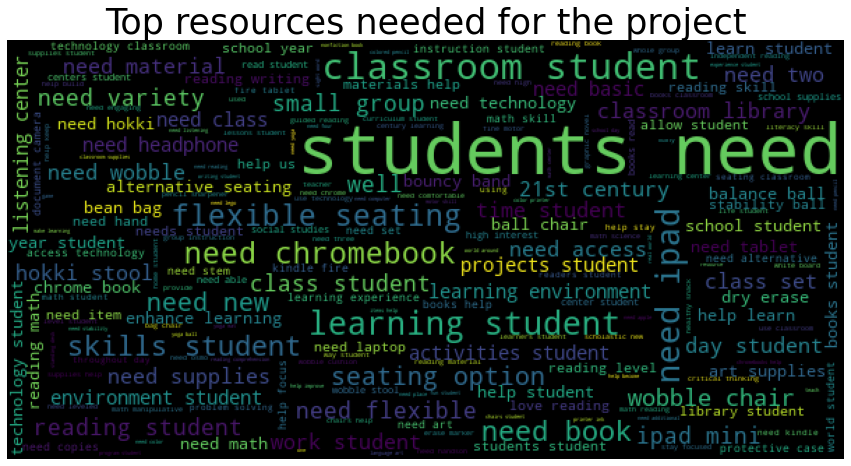

In [24]:
temp_data = train_data.dropna(subset=['project_resource_summary'])
# converting into lowercase
temp_data['project_resource_summary'] = temp_data['project_resource_summary'].apply(lambda x: " ".join(x.lower() for x in x.split()))
temp_data['project_resource_summary'] = temp_data['project_resource_summary'].map(text_prepare)

from wordcloud import WordCloud

wordcloud = WordCloud(max_font_size=50, width=600, height=300).generate(' '.join(temp_data['project_resource_summary'].values))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.title("Top resources needed for the project", fontsize=35)
plt.axis("off")
plt.show()

    As you can see that, form amazing wordcloud representation we can look at the top resource needed for the project

    Since the needed resource was visualised its also important to visualise the requested resource from the "description " column of resource table

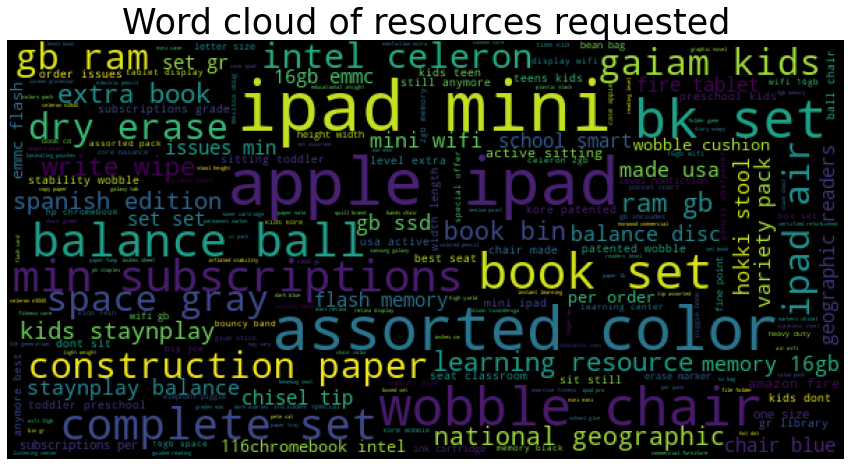

In [25]:
temp_data = train_resource.dropna(subset=['description'])
# converting into lower case
temp_data['description'] = temp_data['description'].apply(lambda x: " ".join(x.lower() for x in x.split()))
temp_data['description'] = temp_data['description'].map(text_prepare)

from wordcloud import WordCloud

wordcloud = WordCloud(max_font_size=50, width=600, height=300).generate(' '.join(temp_data['description'].values))
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud)
plt.title("Word cloud of resources requested", fontsize=35)
plt.axis("off")
plt.show()

    More prominent resources appear in bigger font than the other as you can see it from the wordcloud.

As a part of exploratory data analysis there is lots to explore I will be listing some of those -
1. Popular school states in terms of project acceptance and rejection rate.
     - project_is_approved has label 1 of accepted and 0 if rejected.

2. Propular category of project in terms of project acceptance and rejection rate.

3. Popular project title in terms of acceptance and rejection rate.

## Corelation matrix and heatmap of training data.
- A corelation matrix is a table showing corelation coefficients between variables.
- Each cell in the table shows the corelation between 2 variables.
- A corelation matrix is used to summarize data, as an input into a more advanced analysis, and as a diagnostic for advanced anlyses(source: https://www.displayr.com/what-is-a-correlation-matrix/)

In [26]:
# teacher_prefix and project_is_approved intervals corelation
cols = ['teacher_prefix', 'project_is_approved']
cm = sns.light_palette("red", as_cmap=True)
pd.crosstab(train_data[cols[0]], train_data[cols[1]]).style.background_gradient(cmap = cm)

In [27]:
# teacher_number_of_previously_posted_projects and project-is_approved intervals corelation

In [28]:
cols = ['teacher_number_of_previously_posted_projects', 'project_is_approved']
cm = sns.light_palette("red", as_cmap=True)
pd.crosstab(train_data[cols[0]], train_data[cols[1]]).style.background_gradient(cmap = cm)

## Corelation matrix and heatmap of training data

teacher_number_of_previously_posted_projects  \
teacher_number_of_previously_posted_projects                                      1.000000   
project_is_approved                                                               0.065579   

                                              project_is_approved  
teacher_number_of_previously_posted_projects             0.065579  
project_is_approved                                      1.000000

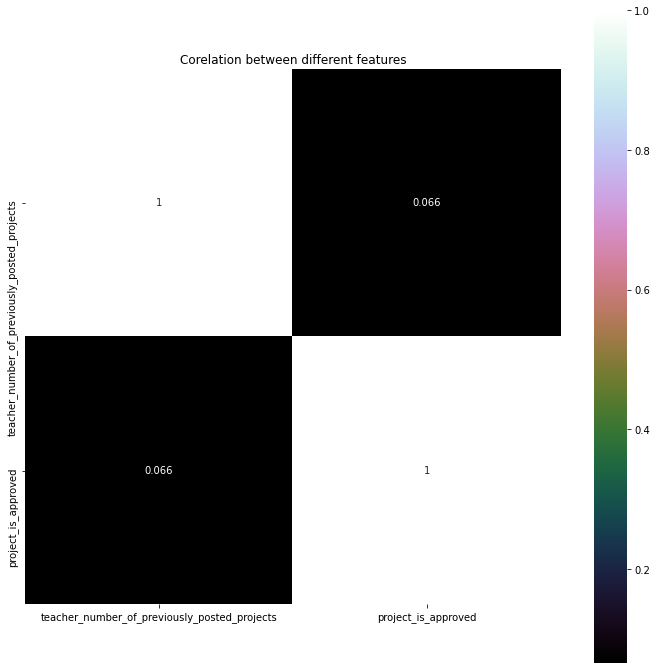

In [29]:
# Corelation Matrix
corr = train_data.corr()
plt.figure(figsize=(12,12))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True, cmap='cubehelix', square=True)
plt.title('Corelation between different features')
corr

### Time analysis of project submission can also be done. for example - 
- Project submission month analysis.
- Project submission weekdays analysis.
- Project submission date analysis.

#### Popular or top project titles in form different states can also be plotted

# Feature engineering

- Its the process of using domain knowledge to extract features form raw data via data mining techniques.
- These features can be used to improve the performance of machine learning algorithms.

In [30]:
cols_to_use = ['id', 'teacher_id', 'teacher_prefix', 'school_state', 'project_submitted_datetime', 'project_grade_category', 'project_subject_categories', 'project_subject_subcategories', 'project_title', 'project_essay_1', 'project_essay_2', 'project_resource_summary', 'teacher_number_of_previously_posted_projects']

y = train_data['project_is_approved']

In [31]:
train_data = train_data[cols_to_use]
test_data = test_data[cols_to_use]

### Total 6 features from project_submitted_datetime
- year
- month
- weekday
- hour
- month_day
- year_day

In [32]:
start_time = time.time()

# Test data
# extracting datetime features using project_submitted_datetime 
train_data['project_submitted_datetime'] = pd.to_datetime(train_data['project_submitted_datetime'])
test_data['project_submitted_datetime'] = pd.to_datetime(test_data['project_submitted_datetime'])

train_data["year"] = train_data["project_submitted_datetime"].dt.year
train_data["month"] = train_data["project_submitted_datetime"].dt.month
train_data['weekday'] = train_data['project_submitted_datetime'].dt.weekday
train_data["hour"] = train_data["project_submitted_datetime"].dt.hour
train_data["month_Day"] = train_data['project_submitted_datetime'].dt.day
train_data["year_Day"] = train_data['project_submitted_datetime'].dt.dayofyear
train_data = train_data.drop('project_submitted_datetime', axis=1)

# Test data
test_data["year"] = test_data["project_submitted_datetime"].dt.year
test_data["month"] = test_data["project_submitted_datetime"].dt.month
test_data['weekday'] = test_data['project_submitted_datetime'].dt.weekday
test_data["hour"] = test_data["project_submitted_datetime"].dt.hour
test_data["month_Day"] = test_data['project_submitted_datetime'].dt.day
test_data["year_Day"] = test_data['project_submitted_datetime'].dt.dayofyear
test_data = test_data.drop('project_submitted_datetime', axis=1)

end_time = time.time()
print("total time in the cuurent cell ",end_time-start_time,"s")

total time in the cuurent cell  0.3613123893737793 s


###  Features created from project_essay_1, project_essay_2, project_title, project_resource_summary
Here we created total 11 features :

- e1_length
- e2_length
- project_title_len
- project_resource_summary_len
- char_count
- word_count
- word_density
- punctuation_count
- title_word_count
- upper_case_word_count
- stopword_count

In [33]:
start_time=time.time()

# Reference for features engineering
# https://www.kaggle.com/shivamb/extensive-feature-engineering-updated/notebook
# train data
train_data['e1_length'] = train_data['project_essay_1'].apply(lambda x: len(str(x))) # Essay1 length
train_data['e2_length'] = train_data['project_essay_2'].apply(lambda x: len(str(x))) # Essay2 length
train_data['project_title_len'] = train_data['project_title'].apply(lambda x: len(str(x))) # Title length
train_data['project_resource_summary_len'] = train_data['project_resource_summary'].apply(lambda x: len(str(x))) # project resource summary length

# combine the project essays to create a complete essay text
train_data['text'] = train_data.apply(lambda row: ' '.join([str(row['project_essay_1']), 
                                            str(row['project_essay_2']), 
                                            ]), axis=1)

# extract features from text
train_data['char_count'] = train_data['text'].apply(len)
train_data['word_count'] = train_data['text'].apply(lambda x: len(x.split()))
train_data['word_density'] = train_data['char_count'] / (train_data['word_count']+1)
train_data['punctuation_count'] = train_data['text'].apply(lambda x: len("".join(_ for _ in x if _ in punctuation))) 
train_data['title_word_count'] = train_data['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
train_data['upper_case_word_count'] = train_data['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
train_data['stopword_count'] = train_data['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.lower() in stop_words]))

# test data
test_data['e1_length'] = test_data['project_essay_1'].apply(lambda x: len(str(x))) # Essay1 length
test_data['e2_length'] = test_data['project_essay_2'].apply(lambda x: len(str(x))) # Essay2 length
test_data['project_title_len'] = test_data['project_title'].apply(lambda x: len(str(x))) # Title length
test_data['project_resource_summary_len'] = test_data['project_resource_summary'].apply(lambda x: len(str(x))) # project resource summary length

# combine the project essays to create a complete essay text
test_data['text'] = test_data.apply(lambda row: ' '.join([str(row['project_essay_1']), 
                                            str(row['project_essay_2']), 
                                            ]), axis=1)

# extract features from text
test_data['char_count'] = test_data['text'].apply(len)
test_data['word_count'] = test_data['text'].apply(lambda x: len(x.split()))
test_data['word_density'] = test_data['char_count'] / (test_data['word_count']+1)
test_data['punctuation_count'] = test_data['text'].apply(lambda x: len("".join(_ for _ in x if _ in punctuation))) 
test_data['title_word_count'] = test_data['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
test_data['upper_case_word_count'] = test_data['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
test_data['stopword_count'] = test_data['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.lower() in stop_words]))

end_time=time.time()
print("total time in the cuurent cell ",end_time-start_time,"s")

total time in the cuurent cell  149.41207551956177 s


####  Features created after combining the training data, test data with resource file

Here we created total 4 features :

- resources_total
- resources_total_mean
- resources_quantity_sum
- resources_quantity_count

In [34]:
start_time=time.time()

# Combine resources file

resources_data['resources_total'] = resources_data['quantity'] * resources_data['price']

dfr_sum = resources_data.groupby(['id'], as_index=False)[['resources_total']].sum()
dfr_mean = resources_data.groupby(['id'], as_index=False)[['resources_total']].mean()
dfr_mean = dfr_mean.rename(columns={'resources_total':'resources_total_mean'})
dfq_sum = resources_data.groupby(['id'], as_index=False)[['quantity']].sum()
dfq_sum = dfq_sum.rename(columns={'quantity':'resources_quantity_sum'})
dfq_count = resources_data.groupby(['id'], as_index=False)[['quantity']].count()
dfq_count = dfq_count.rename(columns={'quantity':'resources_quantity_count'})

# train data
train_data = pd.merge(train_data, dfr_sum, how='left', on='id').fillna(-1)
train_data = pd.merge(train_data, dfr_mean, how='left', on='id').fillna(-1)
train_data = pd.merge(train_data, dfq_sum, how='left', on='id').fillna(-1)
train_data = pd.merge(train_data, dfq_count, how='left', on='id').fillna(-1)

# test data
test_data = pd.merge(test_data, dfr_sum, how='left', on='id').fillna(-1)
test_data = pd.merge(test_data, dfr_mean, how='left', on='id').fillna(-1)
test_data = pd.merge(test_data, dfq_sum, how='left', on='id').fillna(-1)
test_data = pd.merge(test_data, dfq_count, how='left', on='id').fillna(-1)

end_time=time.time()
print("total time in the cuurent cell ",end_time-start_time,"s")

total time in the cuurent cell  6.972216367721558 s


In [35]:
#  Gender feature creation
gender_mapping = {"Mrs.": "Female", "Ms.":"Female", "Mr.":"Male", "Teacher":"Unknown", "Dr.":"Unknown", np.nan:"Unknown"  }
train_data["gender"] = train_data.teacher_prefix.map(gender_mapping)
test_data["gender"] = test_data.teacher_prefix.map(gender_mapping)

## Convering categorical features into numerical features


In [36]:
from sklearn import preprocessing
def encode_features(df_train, df_test):
  features = [
              'teacher_id',
              'teacher_prefix',
              'school_state',
              'project_grade_category',
              'project_subject_categories',
              'project_subject_subcategories',
              'gender'
  ]
  df_combined = pd.concat([df_train[features], df_test[features]])

  for feature in features:
    le = preprocessing.LabelEncoder()
    le = le.fit(df_combined[feature].astype(str))
    df_train[feature] = le.transform(df_train[feature].astype(str))
    df_test[feature] = le.transform(df_test[feature].astype(str))

  return df_train, df_test

train_data, test_data = encode_features(train_data, test_data)

## Remove unwanted features

In [37]:
cols_to_remove = ['id','project_title','project_essay_1','project_essay_2','text','project_resource_summary']

train_data = train_data.drop(cols_to_remove, axis = 1)
test_data = test_data.drop(cols_to_remove, axis = 1)
features = train_data.columns.values

# Building Machine Learning model.

## LightGBM
- *LightGBM*  is a gradient boosting framework tht uses tree based learning algorithms.
- It is designed to be efficient.

#### Advantages
- Faster training speed and higher efficiency.
- Low memory usage
- Better accuracy
- Capable of handling large-scale data.

In [38]:
print("Building model using Light GBM and finding AUC(Area Under Curve)")
from sklearn.model_selection import train_test_split
X_train_l, X_valid_l, y_train_l, y_valid_l = train_test_split(train_data, y, test_size=0.10, random_state=2018)
params = {
        'boosting_type': 'gbdt', 
        'objective': 'binary',
        'metric': 'auc',
        'max_depth': 7,            # This parameter is used to deal with overfitting
        'num_leaves': 32,
        'learning_rate': 0.02,
        'feature_fraction': 0.80,  # Specifies the fraction of features to be taken for each iteration
        'bagging_fraction': 0.80,
        'bagging_freq': 5,
        'verbose': 0,
        'lambda_l2': 1,
    }  

import lightgbm as lgb
evals_result = {}  # to record eval results for plotting
model_lgb = lgb.train(
        params,
        lgb.Dataset(X_train_l, y_train_l),
        num_boost_round=10000,
        valid_sets=[lgb.Dataset(X_valid_l, y_valid_l)],
        early_stopping_rounds=100,
        evals_result=evals_result,
        verbose_eval=25)
from sklearn.metrics import roc_auc_score
valid_preds_lgb = model_lgb.predict(X_valid_l, num_iteration=model_lgb.best_iteration)
test_preds = model_lgb.predict(test_data, num_iteration=model_lgb.best_iteration)
auc = roc_auc_score(y_valid_l, valid_preds_lgb)
print('AUC:',auc)

Building model using Light GBM and finding AUC(Area Under Curve)
Training until validation scores don't improve for 100 rounds.
[25]	valid_0's auc: 0.716934
[50]	valid_0's auc: 0.719857
[75]	valid_0's auc: 0.722279
[100]	valid_0's auc: 0.72431
[125]	valid_0's auc: 0.725928
[150]	valid_0's auc: 0.727622
[175]	valid_0's auc: 0.728718
[200]	valid_0's auc: 0.729741
[225]	valid_0's auc: 0.730433
[250]	valid_0's auc: 0.730999
[275]	valid_0's auc: 0.73174
[300]	valid_0's auc: 0.732121
[325]	valid_0's auc: 0.732379
[350]	valid_0's auc: 0.732688
[375]	valid_0's auc: 0.733039
[400]	valid_0's auc: 0.733212
[425]	valid_0's auc: 0.73356
[450]	valid_0's auc: 0.73374
[475]	valid_0's auc: 0.733931
[500]	valid_0's auc: 0.734054
[525]	valid_0's auc: 0.734033
[550]	valid_0's auc: 0.73404
[575]	valid_0's auc: 0.733869
[600]	valid_0's auc: 0.734193
[625]	valid_0's auc: 0.73425
[650]	valid_0's auc: 0.734335
[675]	valid_0's auc: 0.734316
[700]	valid_0's auc: 0.734285
[725]	valid_0's auc: 0.734322
[750]	valid

## XGBoost model
    In boosting, trees are built sequentially such that each subsequent tree aims to reduce the error of the previous tree.

- The base learners are weak learners in which bias is high.
- Each of these weak learners contributes some vital information for prediction, enabling the boosting technique to produce a strong learner by effectively combining these weak learners.
- the final strong learner brings down both bias and variance.

#### Features of XGBoost
- *Regularization*: XGBoost has an option to penalize complex models through both L1 and L2 regularization. Regularization helps in preventing overfitting.
- *Handling sparse data*: Missing values or data processing steps like one-hot encoding make data sparse. XGBoost incorporates a sparsity-aware split finding algorithm to handle different types of sparsity patterns in the data.
- 

In [39]:
print("Building model using XGBoost and finding AUC(Area Under Curve)")

import xgboost as xgb
xgb_params = {'eta': 0.2, 
                  'max_depth': 5, 
                  'subsample': 0.8, 
                  'colsample_bytree': 0.8, 
                  'objective': 'binary:logistic', 
                  'eval_metric': 'auc', 
                  'seed': 1234
                 }
X_train_x, X_valid_x, y_train_x, y_valid_x = train_test_split(train_data, y, test_size=0.33, random_state=2018)
d_train = xgb.DMatrix(X_train_x, y_train_x)
d_valid = xgb.DMatrix(X_valid_x, y_valid_x)
d_test = xgb.DMatrix(test_data)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]
model_xgb = xgb.train(xgb_params, d_train, 500, watchlist, verbose_eval=50, early_stopping_rounds=20)
xgb_pred_test = model_xgb.predict(d_test)
xgb_pred_valid = model_xgb.predict(d_valid)
auc = roc_auc_score(y_valid_x, xgb_pred_valid)
print('AUC:',auc)

Building model using XGBoost and finding AUC(Area Under Curve)
[0]	train-auc:0.701513	valid-auc:0.693579
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 20 rounds.
[50]	train-auc:0.758214	valid-auc:0.721582
Stopping. Best iteration:
[59]	train-auc:0.764795	valid-auc:0.721952

AUC: 0.7208908866773212


# ROC AUC Curve

- The ROC AUC Score is the corresponding score to ROC AUC curve. Its simply computed by area under the curve.

- A classifier that is 100% correct, would have a ROC AUC score of 1 and a completly random classifier would have a score of 0.5

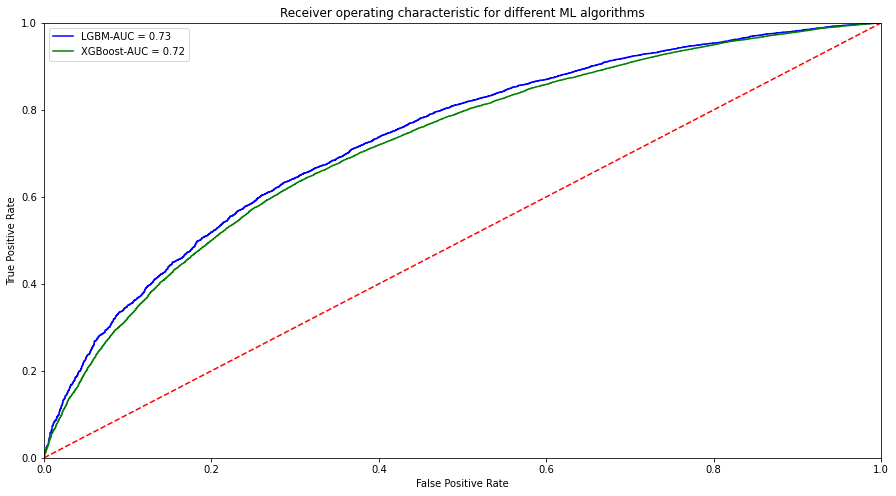

In [41]:
from sklearn.metrics import roc_curve
from sklearn import metrics
fpr, tpr, threshold = roc_curve(y_valid_l, valid_preds_lgb)
roc_auc = metrics.auc(fpr, tpr)

fpr_l, tpr_l, threshold_l = roc_curve(y_valid_x, xgb_pred_valid)
roc_auc_l = metrics.auc(fpr_l, tpr_l)

plt.figure(figsize=(15, 8))

plt.title("Receiver operating characteristic for different ML algorithms")

plt.plot(fpr, tpr, 'b', label = 'LGBM-AUC = %0.2f' % roc_auc)
plt.plot(fpr_l, tpr_l, 'g', label = 'XGBoost-AUC = %0.2f' % roc_auc_l)


plt.legend(loc = 'upper left')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.show()

## Precision Recall Curve

- Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced. In information retrieval, precision is a measure of result of relevancy, while recall is the measure of how many truly relevant results are returned.

-  A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate.

-  An ideal system with high precision and high recall will return many results, with all results labeled correctly.


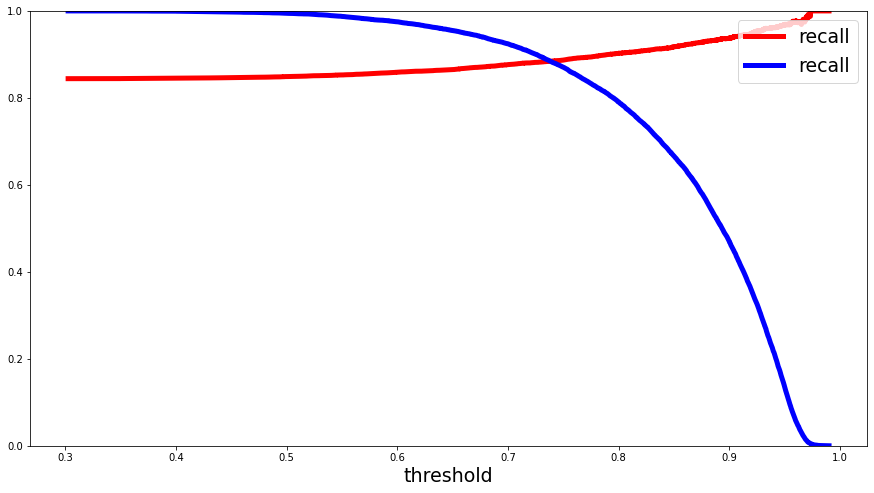

In [42]:
from sklearn.metrics import precision_recall_curve
precision, recall, threshold = precision_recall_curve(y_valid_l, valid_preds_lgb)

def plot_precision_and_recall(precision, recall, threshold):
  plt.plot(threshold, precision[:-1], 'r-', label='recall', linewidth=5)
  plt.plot(threshold, recall[:-1], "b", label='recall', linewidth=5)
  plt.xlabel('threshold', fontsize=19)
  plt.legend(loc='upper right', fontsize=19)
  plt.ylim([0, 1])

plt.figure(figsize=(15, 8))
plot_precision_and_recall(precision, recall, threshold)
plt.show()

## Conclusion
- Training data is highly imbalanced that is approx. 85% of projects were approved and 15% projects were not approved. Majority of class is positive.

       Techniques to handle Imbalanced dataset ----
      - Use right evaluation metrics(Precision, recall, F1 score, AUC)
      - MCC: correlation coefficient between the observed and predicted binary classifications.
      - Resample the training set
      -  Use K-fold Cross-Validation in the right way
      - Cluster the abundant class
      - Design your own models

- Mostly price requested for resources is between approx. 0 to 4k Dollar for all type of project grade categories.

- September month has the second highest number of proposals.